### Compare epsilon to Lombardo&Gregg epsilon

In [2]:
%matplotlib inline

import sys
sys.path.append('../src/')

import glob
import warnings

import numpy as np
import pandas as pd
import xarray as xr

from scipy.optimize import curve_fit, minimize

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from cmocean import cm
import hvplot.xarray

from sklearn.linear_model import LinearRegression

from epsilon_tools import *
from tools import str2date, avg_funs

import warnings
warnings.simplefilter("ignore",category=FutureWarning)
warnings.simplefilter("ignore",category=RuntimeWarning)

# set up figure params
sns.set(style='ticks', context='poster', palette='colorblind')
mpl.rc('figure', dpi=100, figsize=[12, 6])
mpl.rc('savefig', dpi=500, bbox='tight')
mpl.rc('legend', frameon=False)

### load data

In [15]:
floatid = '7781a'
data = xr.open_dataset(f'../data/turb/turb_{floatid}.nc')

### compare L&G prediction to measured $\epsilon$

Lombardo & Gregg scaling:

If $0 < -z \ll -L $,
$$
\epsilon_s = \frac{u^{*3}}{\kappa z}.
$$
If $-L \ll -z \ll D$,
$$
\epsilon_f = J_b^0.
$$
If $-L \ll -z < D$,
$$
\epsilon_{ML} = J_b^0.
$$

(-300, 0)

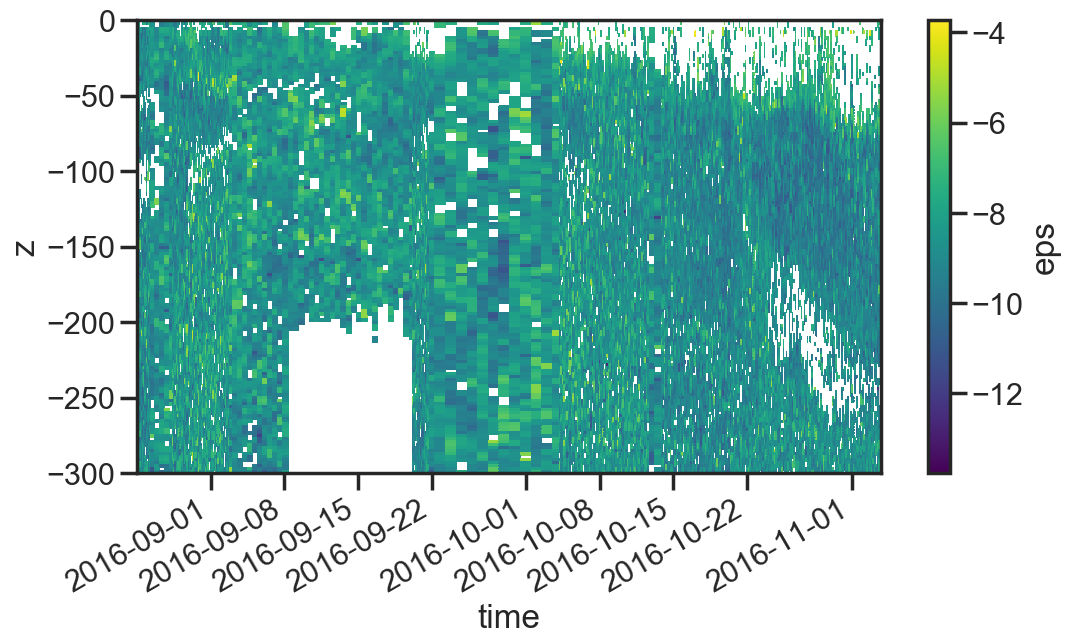

In [77]:
data.eps.pipe(np.log10).plot()
plt.ylim(-300,0)

In [154]:
data['eps_lg'] = data.eps/(0.58*data.B + 1.76*data.mshear_prod)

(-300, 0)

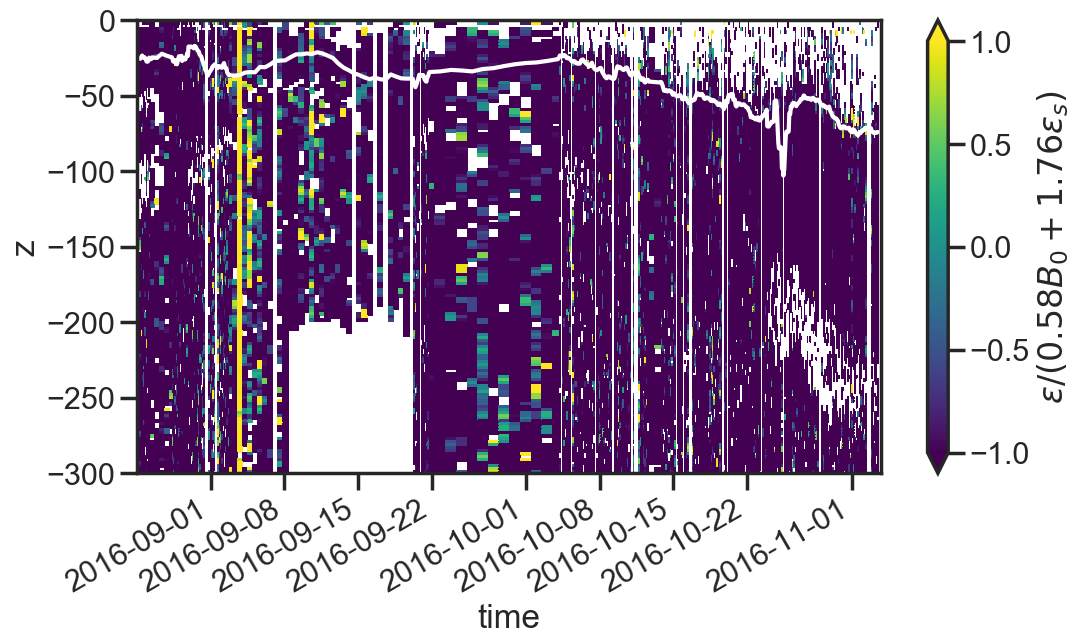

In [35]:
data.mld.plot(color='w')
h = data.eps_lg.pipe(np.log10).plot(vmin=-1,vmax=1, cbar_kwargs={'label':r'$\epsilon/(0.58B_0 + 1.76\epsilon_s)$'})
# plt.colorbar(h,label=r'$\epsilon/(0.58B_0 + 1.76\epsilon_s)$')
plt.ylim(-300,0)

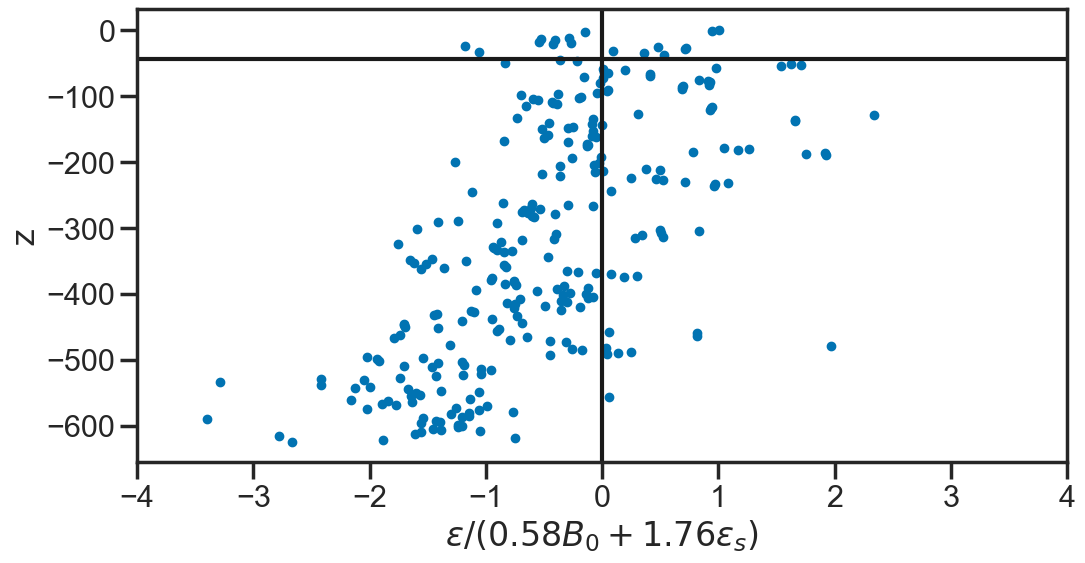

In [155]:
data['eps_lg'].mean(dim='time').pipe(np.log10).plot(y='z', marker='.', lw=0)
plt.xlabel(r'$\epsilon/(0.58B_0 + 1.76\epsilon_s)$')
plt.xlim(-4,4)
plt.axvline(0, color='k')
plt.axhline(data['mld'].mean('time'), color='k')

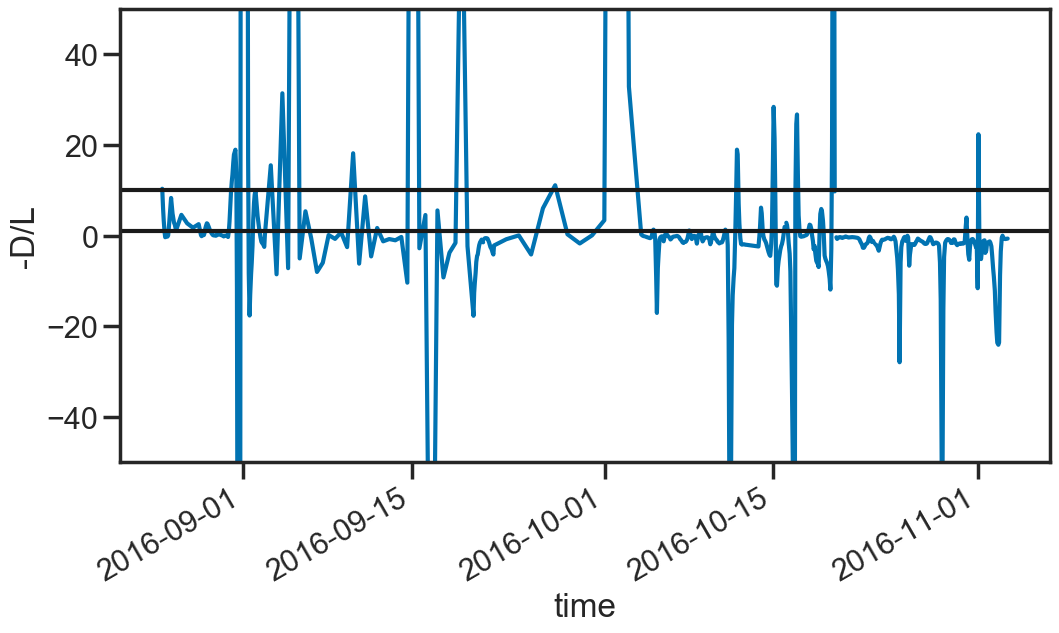

In [136]:
data['-D/L'] = data.mld/data.MO
data['-D/L'].plot()
plt.ylim(-50,50)
plt.axhline(1, color='k')
plt.axhline(10, color='k')

0.36522770173145575


Text(0.5, 1.0, '')

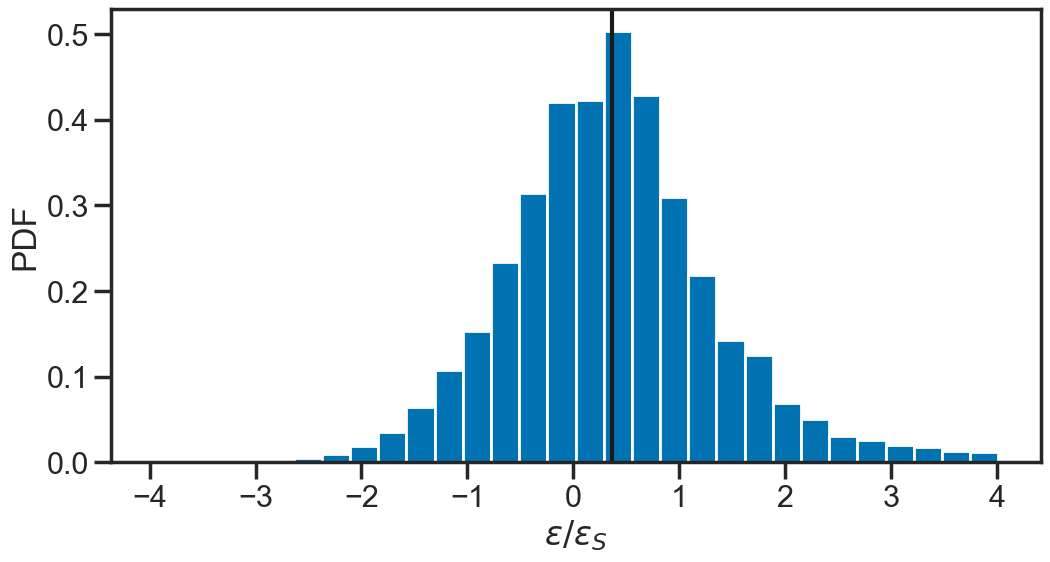

In [148]:
data['meps/eps_s'] = (data.meps/data.shear_prod).where(data['-D/L']<1)
data['meps/eps_s'].pipe(np.log10).plot.hist(density=True, bins=30)
plt.axvline(data['meps/eps_s'].pipe(np.log10).mean(), color='k')
print(data['meps/eps_s'].pipe(np.log10).mean().values)
# plt.xlim(-5,5)
plt.ylabel('PDF')
plt.xlabel(r'$\epsilon/\epsilon_S$')
plt.title(None)

<xarray.DataArray 'meps/B0' ()>
array(0.62768869)


Text(0.5, 0, '$\\epsilon/B_0$')

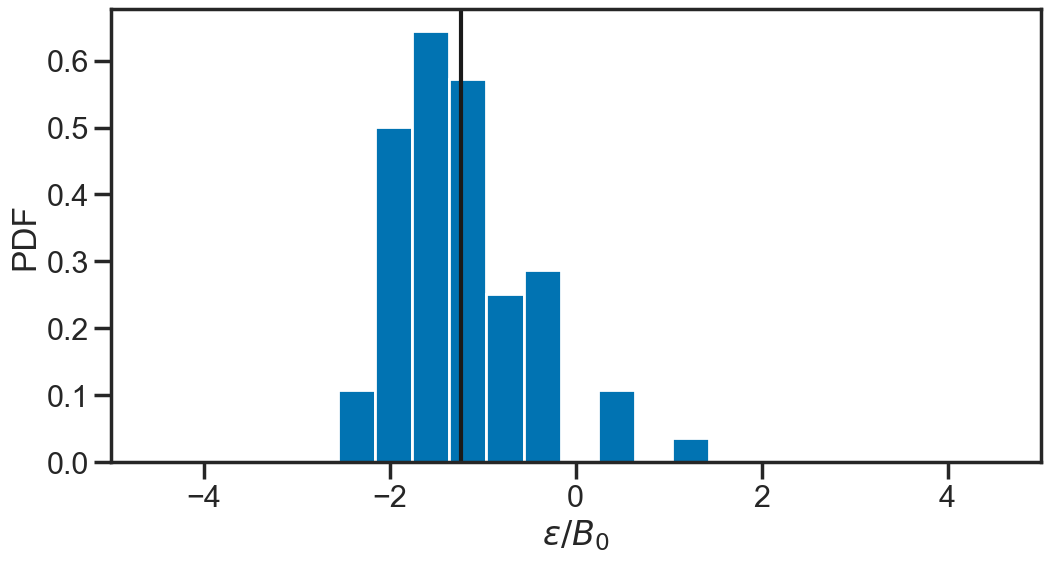

In [147]:
data['meps/B0'] = (data.meps/data.B).where(data['-D/L']>1)
data['meps/B0'].pipe(np.log10).dropna('time').plot.hist(density=True)
plt.axvline(data['meps/B0'].pipe(np.log10).mean(), color='k')
print(data['meps/B0'].mean())
plt.xlim(-5,5)
plt.ylabel('PDF')
plt.title(None)
plt.xlabel(r'$\epsilon/B_0$')

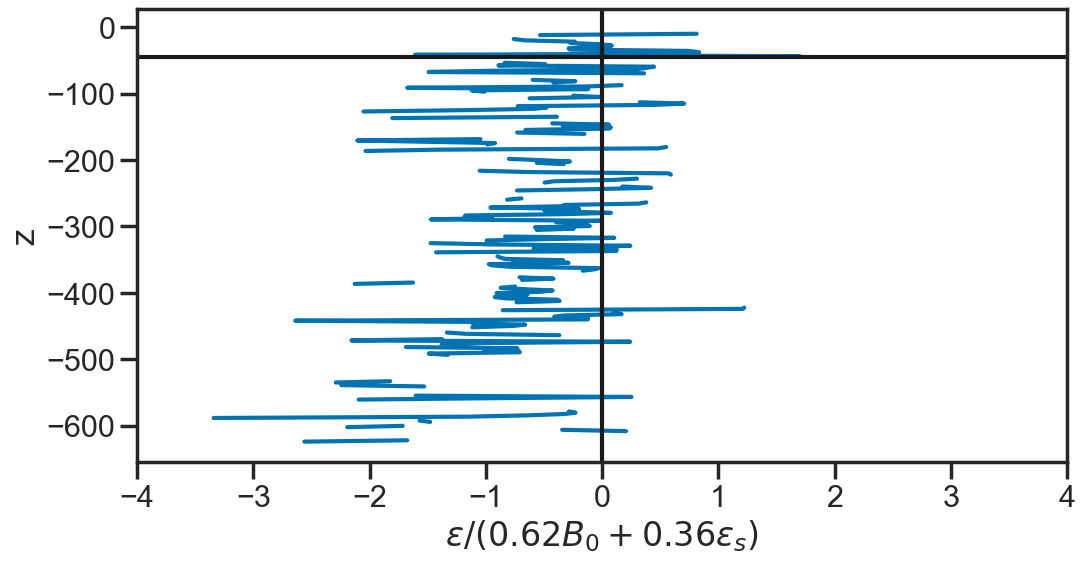

In [151]:
data['eps_lg_new'] = data.eps/(0.62*data.B + 0.36*data.mshear_prod)

data['eps_lg_new'].mean(dim='time').pipe(np.log10).plot(y='z')
plt.xlabel(r'$\epsilon/(0.62B_0 + 0.36\epsilon_s)$')
plt.xlim(-4,4)
plt.axvline(0, color='k')
plt.axhline(data['mld'].mean('time'), color='k')